In this notebook we set up RACS beams for source-finding with Aegean. We need to squish the beams along the frequency axis to obtain a total polarisation image and a total intensity image.

In [2]:
from multiprocessing.pool import Pool

from astropy.convolution import convolve, Gaussian2DKernel
import matplotlib.pyplot as plt
import numpy
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [51]:
beam = '04'

In [52]:
Q = fits.open(f'/home/alger/possum/racs/image.restored.q.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
U = fits.open(f'/home/alger/possum/racs/image.restored.u.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')
I = fits.open(f'/home/alger/possum/racs/image.restored.i.SB8583.contcube.RACS_test4_1.05_0538-31A.beam{beam}.fits',
              mode='denywrite')

In [53]:
# From gheald/quocka
def smoothloop(args):
    data, head, freq, freq_r = args
    if freq == freq_r:
        return data
    freq_r = head['CRVAL4']
    bmaj = head['BMAJ'] * (freq_r) / freq
    bmin = head['BMIN'] * (freq_r) / freq
    pa = numpy.deg2rad(head['BPA'])
    conv_width_maj = numpy.sqrt(head['BMAJ'] ** 2 - bmaj ** 2)  # arcmin
    conv_width_min = numpy.sqrt(head['BMIN'] ** 2 - bmin ** 2)  # arcmin
    px_scale = abs(head['CDELT1'])
    sig_min = conv_width_min / (2 * numpy.sqrt(2 * numpy.log(2))) / px_scale
    sig_maj = conv_width_maj / (2 * numpy.sqrt(2 * numpy.log(2))) / px_scale
    g = Gaussian2DKernel(
        sig_min,
        sig_maj,
        theta=pa)
    data = convolve(data, g, boundary='extend') * (2 * numpy.pi * sig_min * sig_maj)
    return data

In [54]:
def smooth_cube(cube):
    data = cube[0].data
    head = cube[0].header
    data = data[:, 0, :, :]
    n_channels = len(data)
    freqs = numpy.arange(head['CRVAL4'], head['CRVAL4'] + head['CDELT4'] * n_channels, head['CDELT4'])
    assert len(freqs) == n_channels
    args = [[channel, head, freq, head['CRVAL4']] for channel, freq in zip(data, freqs)]
    with Pool(8) as pool:
        output = pool.imap(smoothloop, args)
        output = [i for i in tqdm(output, total=len(args))]
    return output

In [50]:
output = smooth_cube(I)

TypeError: buffer is too small for requested array

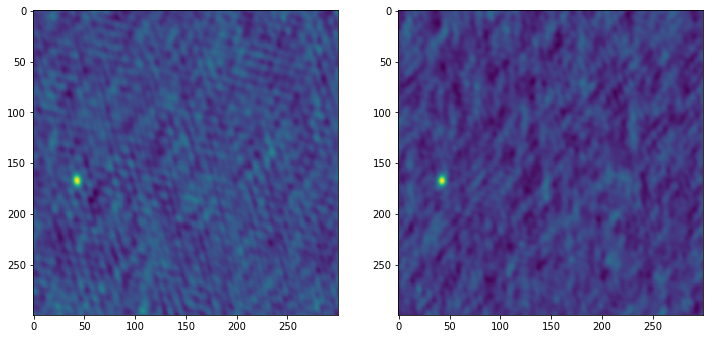

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(output[0][1200:1500, 1200:1500])
plt.subplot(1, 2, 2)
plt.imshow(output[-1][1200:1500, 1200:1500])

In [33]:
total_I = numpy.sum(output, axis=0)
total_I /= len(total_I)
total_I_header = I[0].header.copy()
total_I_fits = fits.PrimaryHDU(data=total_I[None, None, :, :], header=total_I_header)
total_I_fits.writeto(f'/home/alger/possum/racs/squished/I_{beam}.fits', overwrite=True)

In [56]:
smooth_Q = smooth_cube(Q)

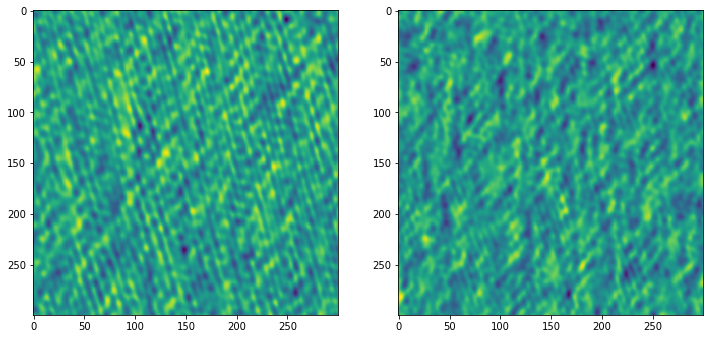

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(smooth_Q[0][1200:1500, 1200:1500])
plt.subplot(1, 2, 2)
plt.imshow(smooth_Q[-1][1200:1500, 1200:1500])

In [11]:
smooth_Q_ = numpy.array(smooth_Q)
smooth_Q_header = Q[0].header.copy()
smooth_Q_fits = fits.PrimaryHDU(data=smooth_Q_[None, None, :, :], header=smooth_Q_header)

In [12]:
total_Q = numpy.sum(smooth_Q, axis=0)
total_Q /= len(total_Q)
total_Q_header = Q[0].header.copy()
total_Q_fits = fits.PrimaryHDU(data=total_Q[None, None, :, :], header=total_Q_header)

In [13]:
total_Q_fits.writeto(f'/home/alger/possum/racs/squished/Q_{beam}.fits', overwrite=True)

In [14]:
smooth_Q_fits.writeto(f'/home/alger/possum/racs/squished/Q_smooth_{beam}.fits', overwrite=True)

In [15]:
smooth_U = smooth_cube(U)

In [16]:
total_U = numpy.sum(smooth_U, axis=0)
total_U /= len(total_U)
total_U_header = U[0].header.copy()
total_U_fits = fits.PrimaryHDU(data=total_U[None, None, :, :], header=total_U_header)
total_U_fits.writeto(f'/home/alger/possum/racs/squished/U_{beam}.fits', overwrite=True)

In [17]:
smooth_U_ = numpy.array(smooth_U)
smooth_U_header = U[0].header.copy()
smooth_U_fits = fits.PrimaryHDU(data=smooth_U_[None, None, :, :], header=smooth_U_header)

In [18]:
smooth_U_fits.writeto(f'/home/alger/possum/racs/squished/U_smooth_{beam}.fits', overwrite=True)

In [19]:
smooth_P = []
for q, u in zip(tqdm(smooth_Q), smooth_U):
    p = numpy.sqrt(q ** 2 + u ** 2)
    smooth_P.append(p)

In [20]:
total_P = numpy.sum(smooth_P, axis=0)
total_P /= len(total_P)
total_P_header = U[0].header.copy()
total_P_fits = fits.PrimaryHDU(data=total_P[None, None, :, :], header=total_P_header)
total_P_fits.writeto(f'/home/alger/possum/racs/squished/P_{beam}.fits', overwrite=True)

In [21]:
smooth_P_ = numpy.array(smooth_P)
smooth_P_header = Q[0].header.copy()
smooth_P_fits = fits.PrimaryHDU(data=smooth_P_[None, None, :, :], header=smooth_P_header)

NameError: name 'dffd' is not defined